In [1]:
# clustering_batch.py : à lancer 1x/mois (cron ou manuellement)
import pandas as pd, numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from statsmodels.tsa.seasonal import STL
import pickle
# imports standard
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.compose import ColumnTransformer
import plotly.express as px
import warnings; warnings.filterwarnings("ignore")
from kneed import KneeLocator
from scipy.cluster.hierarchy import linkage, dendrogram
from IPython.display import Markdown

%matplotlib inline



In [2]:

# 1. KMeans : elbow + silhouette
def optimal_k_kmeans(X, k_range):
    ks = list(k_range)
    inertias, silhouettes = [], []
    for k in ks:
        km = KMeans(n_clusters=k, random_state=42).fit(X)
        inertias.append(km.inertia_)  # WCSS 
        silhouettes.append(silhouette_score(X, km.labels_))  # silhouette 
    kl = KneeLocator(ks, inertias, curve='convex', direction='decreasing')
    # Representation de l'elbow et la silhouette
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(ks, inertias, marker='o')
    plt.title("WCSS vs k")
    plt.xlabel("Nombre de clusters (k)")
    plt.ylabel("WCSS (Inertie)")
    plt.subplot(1, 2, 2)
    plt.plot(ks, silhouettes, marker='o')
    plt.title("Silhouette vs k")
    plt.xlabel("Nombre de clusters (k)")
    plt.ylabel("Score de silhouette")
    plt.tight_layout()
    plt.show()
    return kl.elbow, ks[np.argmax(silhouettes)], inertias, silhouettes

# 2. CAH : dendrogramme + “inertie” manuelle + silhouette
def optimal_k_agglo(X, k_range):
    # 2.1 Affichage du dendrogramme pour repérer visuellement l’“elbow” 
    Z = linkage(X, method='ward')
    plt.figure(figsize=(20, 5))
    dendrogram(Z)
    plt.title("Dendrogramme (CAH)")
    plt.xlabel("Échantillons")
    plt.ylabel("Distance")
    plt.show()
    # 2.2 Calculs automatiques
    ks = list(k_range)
    inertias, silhouettes = [], []
    for k in ks:
        ac = AgglomerativeClustering(n_clusters=k, linkage='ward').fit(X)
        labels = ac.labels_
        silhouettes.append(silhouette_score(X, labels))  # silhouette 
        # Calcul WCSS “à la main” :
        centroids = np.array([X[labels==i].mean(axis=0) for i in range(k)])
        wcss = sum(np.sum((X[labels==i] - centroids[i])**2) for i in range(k))
        inertias.append(wcss)
    kl = KneeLocator(ks, inertias, curve='convex', direction='decreasing')
    
    # Representation de l'elbow et la silhouette
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(ks, inertias, marker='o')
    plt.title("WCSS vs k")
    plt.xlabel("Nombre de clusters (k)")
    plt.ylabel("WCSS (Inertie)")
    plt.subplot(1, 2, 2)
    plt.plot(ks, silhouettes, marker='o')
    plt.title("Silhouette vs k")
    plt.xlabel("Nombre de clusters (k)")
    plt.ylabel("Score de silhouette")
    plt.tight_layout()
    plt.show()
    return kl.elbow, ks[np.argmax(silhouettes)], inertias, silhouettes


In [3]:
def extract_features(df, cols, period=12):
    feats = []
    for c in cols:
        s = df[c].dropna()
        if len(s) < 24:
            row = {"trend":0, "yoy":0, "season":0, "volatility":0, "cv":0}
        else:
            row = {
                "trend": np.polyfit(range(len(s)), s, 1)[0],
                "yoy": s.pct_change(period).mean()*100,
                "season": STL(s, period=period, robust=True).fit().seasonal.std(),
                "volatility": s.pct_change().std()*100,
                "cv": s.std()/s.mean() if s.mean() != 0 else 0
            }
        feats.append(row)
    return pd.DataFrame(feats, index=cols)


In [4]:
# 4. Comparaison finale
def compare_models(X, labels_dict):
    results = []
    for name, labels in labels_dict.items():
        results.append({
            'Modèle': name,
            'Silhouette': silhouette_score(X, labels),               # :contentReference[oaicite:5]{index=5}
            'Calinski–Harabasz': calinski_harabasz_score(X, labels), # :contentReference[oaicite:6]{index=6}
            'Davies–Bouldin': davies_bouldin_score(X, labels)        # :contentReference[oaicite:7]{index=7}
        })
    import pandas as pd
    return pd.DataFrame(results)


In [5]:

# Attribuer des noms automatiques aux clusters
def name_cluster(df):
    if df['trend'].mean() > 0.3 and df['season'].mean() > 0.8:
        return "Saisonnier à forte inflation"
    if df['trend'].mean() < 0.1 and df['season'].mean() < 0.4:
        return "Stable et peu saisonnier"
    if df['volatility'].mean() > 6:
        return "Très volatil"
    return "Mixte ou modéré"
    


In [6]:
# Calcul sur la période d’étude principale
df = pd.read_csv("data/Base_fin.csv", index_col=0, parse_dates=True)
cols = [c for c in df.columns if c not in ['IHPC','Inflation','InflationGliss', 'mois_deb_couv','annee_fin_couv','mois_fin_couv']]
X = extract_features(df, cols)

scaler = StandardScaler()
X_std = scaler.fit_transform(X)

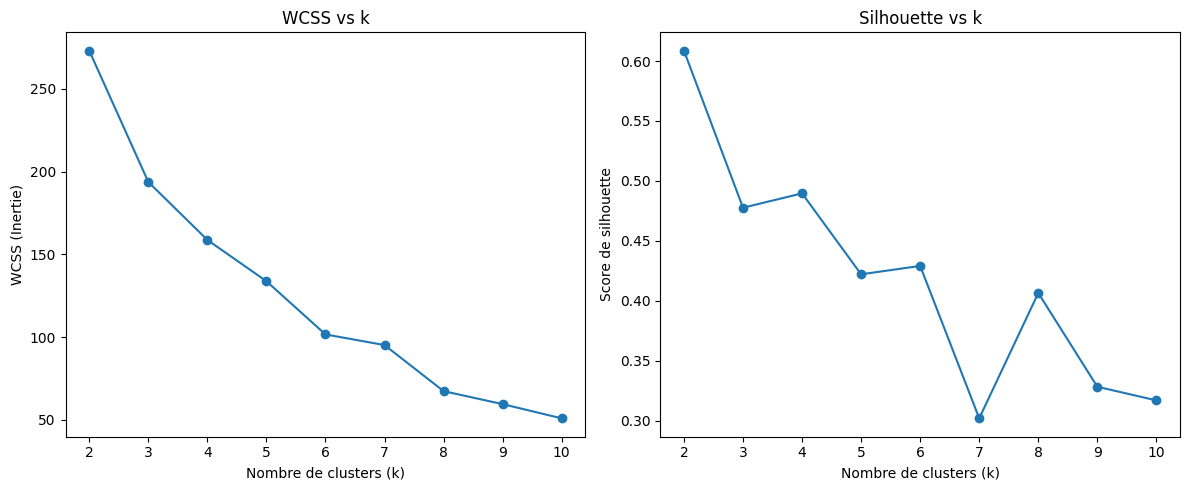

KMeans optimal (elbow): 8, (silhouette): 2


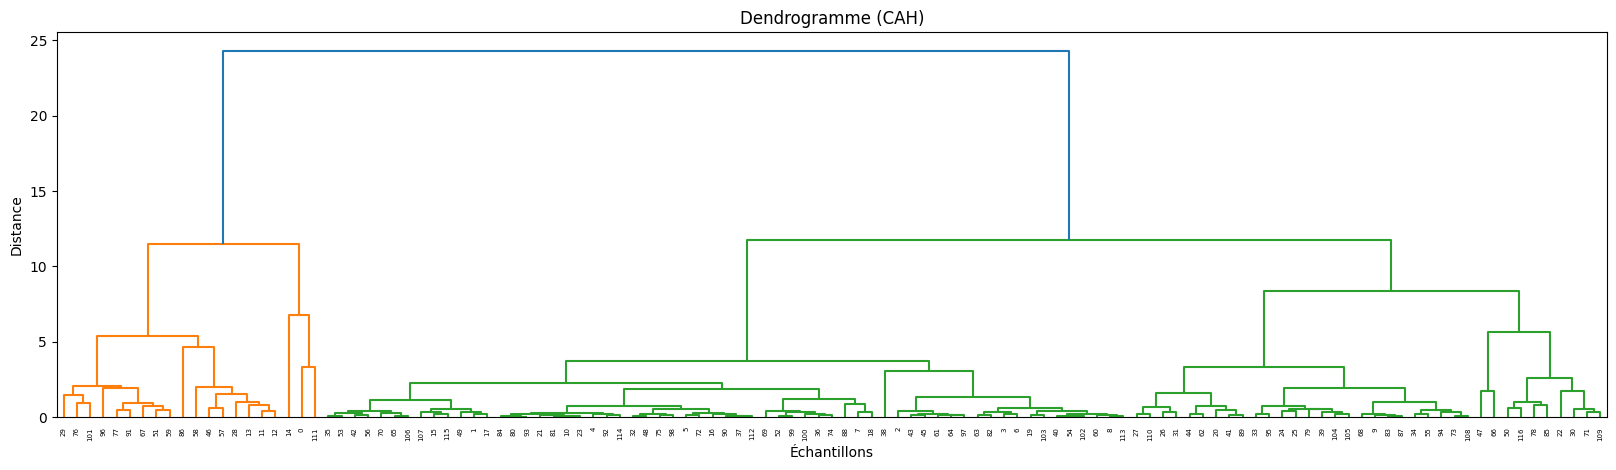

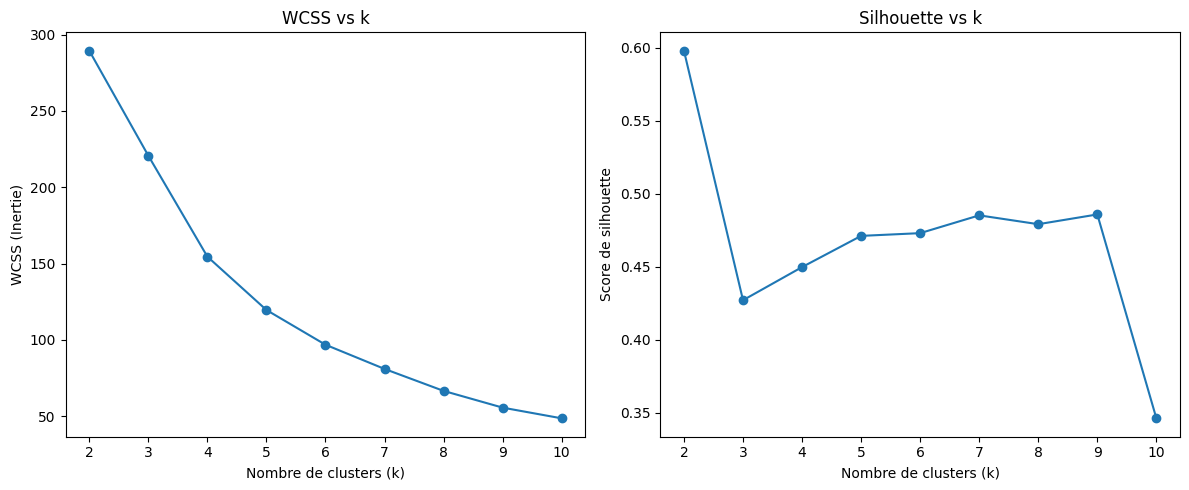

CAH optimal (elbow): 5, (silhouette): 2


In [7]:
# --- UTILISATION SUR MON JEU DE DONNÉES X_pca ---
ks = range(3, 11)

# GRID-SEARCH
ks = range(2, 11)  # Si vous voulez tester un autre interval   

# KMeans
k_elbow_km, k_sil_km, inert_km, sil_km = optimal_k_kmeans(X_std, ks)
print(f"KMeans optimal (elbow): {k_elbow_km}, (silhouette): {k_sil_km}")

# CAH
k_elbow_ac, k_sil_ac, inert_ac, sil_ac = optimal_k_agglo(X_std, ks)
print(f"CAH optimal (elbow): {k_elbow_ac}, (silhouette): {k_sil_ac}")

In [8]:
# Génération des labels finaux
labels_km = KMeans(n_clusters=3, random_state=42).fit_predict(X_std)
labels_ac = AgglomerativeClustering(n_clusters=4, linkage='ward').fit_predict(X_std)

In [10]:
X['Cluster_KMeans'] = labels_km
X['Cluster_CAH'] = labels_ac

In [11]:
X

,trend,yoy,season,volatility,cv,Cluster_KMeans,Cluster_CAH
AGRUMES,0.437455,5.497383,16.157858,11.949947,0.183596,2,1
ALCOOL_DE_BOUCHE,0.181025,2.099274,1.267973,1.830157,0.050959,0,2
APPAREILS_DE_RECEPTION_ENREGISTREMENT_ET_REPRODUCTION,-0.094251,-0.705816,0.732477,1.286714,0.034974,0,2
APPAREILS_ET_ARTICLES_POUR_SOINS_CORPORELS,-0.009909,-0.049390,0.461775,1.833570,0.016421,0,2
APPAREILS_ET_MATERIEL_THERAPEUTIQUES,0.052335,0.420991,0.746623,0.825483,0.019508,0,2
...,...,...,...,...,...,...,...
VETEMENTS_DE_DESSUS_FEMMES,0.097531,1.085216,0.669299,1.113213,0.027531,0,2
VETEMENTS_DE_DESSUS_HOMMES,0.013322,0.231782,0.525113,0.716989,0.007893,0,2
VETEMENTS_ENFANTS_(3_A_13_ANS)_ET_NOURRISSONS_(0_A_2_ANS),0.061251,0.811519,0.764156,1.037774,0.018398,0,2
VIN_ET_BOISSONS_FERMENTEES,0.159301,1.839786,0.845122,1.262419,0.041518,0,2


In [31]:
fig = px.scatter_3d(
    X, x='trend', y='volatility', z='season',
    color='Cluster_KMeans',
    title="KMEANS----Projection interactive des clients sur PC1, PC2, PC3",
    opacity=0.7,
    width=1000, height=1000,
)

# Fixer la taille des points ici
fig.update_traces(marker=dict(size=10))

fig.show()


In [ ]:
fig = px.scatter_3d(
    X, x='trend', y='volatility', z='season',
    color='Cluster_CAH',
    title="CAH----Projection interactive des clients sur PC1, PC2, PC3",
    opacity=0.7,
    width=1000, height=1000,
)

# Fixer la taille des points ici
fig.update_traces(marker=dict(size=2))

fig.show()


In [61]:
X.groupby('Cluster_KMeans').agg(['mean', 'std', 'min', 'max'])


trend                                     yoy            \
                    mean       std       min       max      mean       std   
Cluster_KMeans                                                               
0               0.072299  0.089467 -0.294808  0.241408  0.847755  0.947820   
1               0.345655  0.161017 -0.123311  0.666988  3.608091  1.150309   
2               0.812405  0.375529  0.437455  1.743221  7.536505  3.126297   

                                       season            ... volatility  \
                     min        max      mean       std  ...        min   
Cluster_KMeans                                           ...              
0              -2.567034   2.717671  0.672926  0.458699  ...   0.397252   
1               1.474982   6.399634  1.761938  1.175290  ...   0.627610   
2               4.929679  15.835414  7.403293  4.047913  ...   4.537904   

                                 cv                               Cluster_CAH  \
                      max      mean       std       min       max        mean   
Cluster_KMeans                                                                  
0                5.212742  0.033016  0.018034  0.007893  0.109796    1.791045   
1               13.075849  0.105862  0.029602  0.056472  0.177856    0.648649   
2               11.983444  0.190407  0.056476  0.135012  0.342325    2.500000   

                                  
                     std min max  
Cluster_KMeans                    
0               0.616375   0   2  
1               1.252025   0   3  
2               0.904534   1   3  

[3 rows x 24 columns]

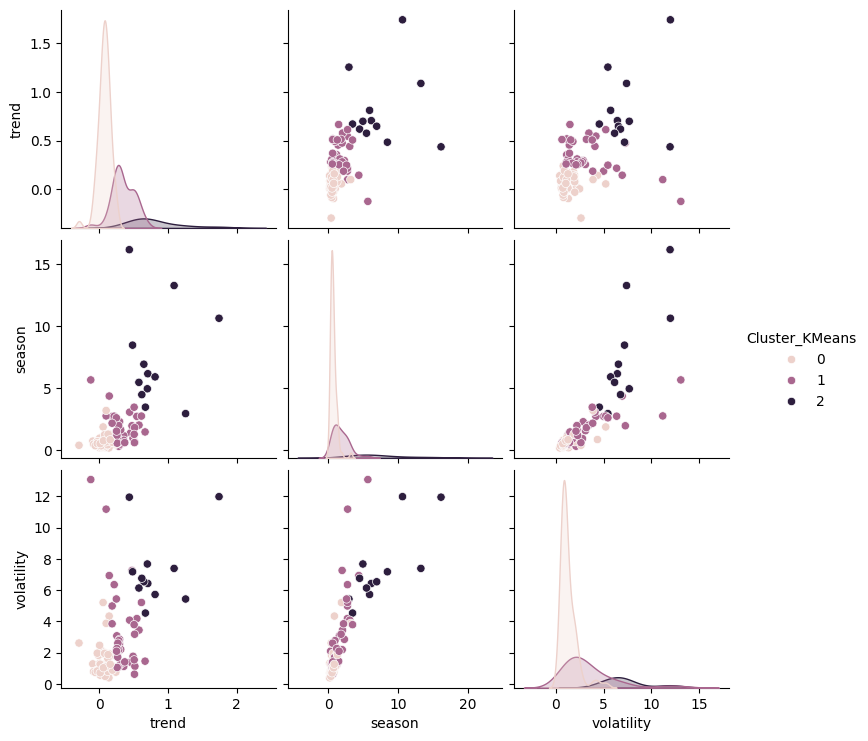

In [57]:
sns.pairplot(X, hue='Cluster_KMeans', vars=['trend', 'season', 'volatility'])
plt.show()

In [30]:
# Tableau comparatif
df_comparison = compare_models(
    X_std,
    {'KMeans': labels_km, 'CAH': labels_ac}
)
print(df_comparison)

   Modèle  Silhouette  Calinski–Harabasz  Davies–Bouldin
0  KMeans    0.477623         115.020948        0.881333
1     CAH    0.449460         104.805736        0.921803


In [ ]:
desc = []
for c in sorted(X['Cluster_KMeans'].unique()):
    sub = X[X['Cluster_KMeans']==c]
    nom = name_cluster(sub)
    desc.append({"cluster":c, "nom":nom,
                 "trend":sub['trend'].mean(),
                 "season":sub['season'].mean(),
                 "volatility":sub['volatility'].mean(),
                 "yoy":sub['yoy'].mean(),
                 "cv":sub['cv'].mean(),
                 "postes": list(sub.index)})
desc_df = pd.DataFrame(desc)

# Sauvegarde résultats
X[['cluster']].to_csv("mapping_clusters.csv")

desc_df.to_csv("desc_clusters.csv", index=False)
print("Clusters calculés et sauvegardés")


In [18]:
d = pd.read_csv("data/Base_long.csv", index_col=0, parse_dates=True)

In [45]:
X.columns

Index(['trend', 'yoy', 'season', 'volatility', 'cv', 'Cluster_KMeans',
       'Cluster_CAH'],
      dtype='object')

In [58]:
d = pd.melt(df, id_vars=['annee_fin_couv','mois_deb_couv'],
                  value_vars=cols,
                  var_name='nom_indicateur', value_name='valeur')

In [59]:
C0 = X[X['Cluster_KMeans'] == 0].index.tolist()
Classe0 = d[d['nom_indicateur'].isin(C0)]

In [60]:
C1 = X[X['Cluster_KMeans'] == 1].index.tolist()
Classe1 = d[d['nom_indicateur'].isin(C1)]

In [61]:
C2 = X[X['Cluster_KMeans'] == 2].index.tolist()
Classe2 = d[d['nom_indicateur'].isin(C2)]

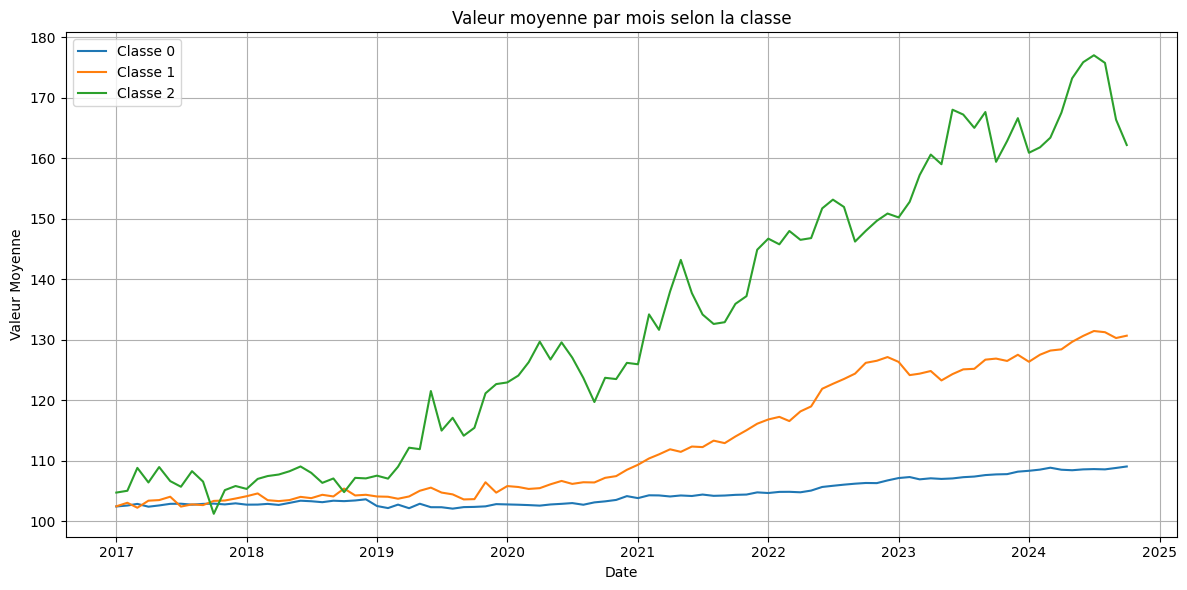

In [62]:
import matplotlib.pyplot as plt
import pandas as pd

# Supposons que Classe0, Classe1, Classe2 existent déjà

# Étape 1: Grouper et prendre la moyenne
g0 = Classe0.groupby(['annee_fin_couv', 'mois_deb_couv'])['valeur'].mean().reset_index()
g1 = Classe1.groupby(['annee_fin_couv', 'mois_deb_couv'])['valeur'].mean().reset_index()
g2 = Classe2.groupby(['annee_fin_couv', 'mois_deb_couv'])['valeur'].mean().reset_index()

# Étape 2: Créer une colonne 'date' pour l'axe X
g0['date'] = pd.to_datetime(g0['annee_fin_couv'].astype(str) + '-' + g0['mois_deb_couv'].astype(str) + '-01')
g1['date'] = pd.to_datetime(g1['annee_fin_couv'].astype(str) + '-' + g1['mois_deb_couv'].astype(str) + '-01')
g2['date'] = pd.to_datetime(g2['annee_fin_couv'].astype(str) + '-' + g2['mois_deb_couv'].astype(str) + '-01')

# Étape 3: Tracer
plt.figure(figsize=(12, 6))
plt.plot(g0['date'], g0['valeur'], label='Classe 0')
plt.plot(g1['date'], g1['valeur'], label='Classe 1')
plt.plot(g2['date'], g2['valeur'], label='Classe 2')

# Ajouts visuels
plt.xlabel('Date')
plt.ylabel('Valeur Moyenne')
plt.title('Valeur moyenne par mois selon la classe')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
